## Imports

In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Подготовка данных
1. Загрузка датасета, подготовленного по результатам предыдущего анализа
2. Разбивка датасета на тренировочную и тестовую выборки

In [3]:
path = '../arabica_data_after_eda.csv'
df = pd.read_csv(path, index_col='Unnamed: 0')

In [4]:
X, y = df.drop(columns=['Total.Cup.Points']), df['Total.Cup.Points']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
X_train.head()

,Owner,Country.of.Origin,Company,Region,Producer,In.Country.Partner,Harvest.Year,Aroma,Flavor,Aftertaste,Acidity,Moisture,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters
643,111,27,126,65,380,23,3,7.83,7.50,7.42,7.58,0.12,0,0.0,2,0,1650.0
157,141,0,146,205,167,14,0,8.00,8.00,7.75,7.75,0.12,0,0.0,2,2,1300.0
635,118,24,185,236,449,17,9,7.67,7.42,7.50,7.42,0.11,0,5.0,2,0,1050.0
1016,121,12,27,98,437,12,11,7.17,7.58,7.50,7.50,0.11,0,0.0,2,3,1600.0
284,58,4,72,31,398,18,3,7.83,7.42,7.50,7.83,0.10,0,0.0,2,3,1300.0


## Построение бейзлайна
Выбрано построение бейзлайна по медианному значению

In [6]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

## Обучение простой модели для сравнения с бейзлайном (как было на лекции)

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

## Использование разных метрик для оценки двух моделей
Поскольку перед нами стоит задача регрессии, можно использовать такие метрики: MSE, RMSE, MAE, MAPE и коэффициент детерминации

In [8]:
print(f'MSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy)}')
print(f'MSE for Linear regression: {mean_squared_error(y_test, y_preds_lr)}')

MSE for Dummy Regressor: 5.8913802083333335
MSE for Linear regression: 1.0229280096919133


In [9]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 2.427216555714247
RMSE for Linear regression: 1.0113990358369507


In [10]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

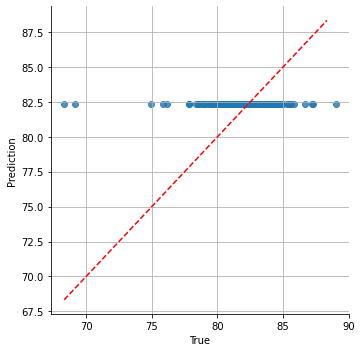

In [11]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')

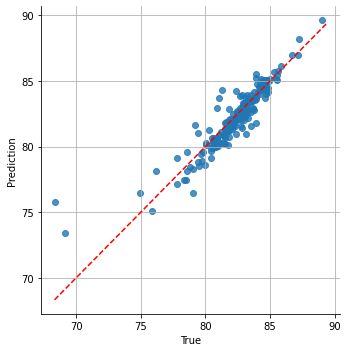

In [12]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

In [13]:
print(f'MAE for Dummy Regressor: {mean_absolute_error(y_test, y_preds_dummy)}')
print(f'MAE for Linear regression: {mean_absolute_error(y_test, y_preds_lr)}')

MAE for Dummy Regressor: 1.6309375000000006
MAE for Linear regression: 0.6351603867718989


In [14]:
print(f'R2 score for Dummy Regressor: {r2_score(y_test, y_preds_dummy)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')

R2 score for Dummy Regressor: -0.0007573302800532034
R2 score for Linear regression: 0.8262372028544441


## Выбор метрики

Выбранная метрика - MAE. Метрика выбрана методом исключения:
- данные содержат выбросы, поэтому штрафовать за ошибку квадратично не хочется (поэтому не используются MSE, RMSE);
- у датасета много столбцов, часть которых возможно придется потом отбросить. Метрика R2 зависит от количества параметров, поэтому с ней возиться не хочется;
- хочется видеть ошибку в единицах измерения целевого параметра, поэтому между оставшимися MAE и MAPE  выбрана MAE.

## Кросс-валидация
Для стратификации использовано округленное значение целевого параметра, так как без округления оказывается много значений в единственном экземпляре. Поскольку данных относительно много, используется метод k-fold без вариации leave-one-out.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=round(y, -1))

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

lr = LinearRegression()
print('Cross validation for linear regression: ', - cross_val_score(lr, X_train_scaled, y_train, cv=4, scoring='neg_mean_absolute_error'))

dummy = DummyRegressor(strategy='median')

print('Cross validation for dummy regression: ', - cross_val_score(dummy, X_train_scaled, y_train, cv=4, scoring='neg_mean_absolute_error'))

Cross validation for linear regression:  [0.78090434 0.64153039 0.7032361  0.65184681]
Cross validation for dummy regression:  [1.66645833 1.47694444 1.86326389 1.77552448]
